# Road Accident Risk Prediction

* **Objective:** The goal of this project is to build a machine learning model to predict the likelihood of road accidents (a continuous value between 0 and 1).

* **Dataset:** The dataset used here is a dataset source from Kaggle. It was generated by a deep learning model  trained on the original Simulated Roads Accident dataset. While its feature distributions are similar to the original simulated dataset, they are not identical.

* **Evaluation:** Model performance will be evaluated using the Root Mean Squared Error (RMSE) between the predicted and actual accident risk values.

# Collect and Prepare Data

## Data Collection

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [12]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
print(df_train.shape)
print(df_test.shape)
df_train.head()

(517754, 14)
(172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


## Data Cleaning

In [13]:
# check missing values
print(df_train.isnull().sum().sum())
print(df_test.isnull().sum().sum())

# check duplicates
print(df_train.duplicated().sum())

# remove ID columns
train_clean = df_train.drop('id', axis=1)
test_clean = df_test.drop('id', axis=1)

# prepare features and target
X = train_clean.drop('accident_risk', axis=1)
y = train_clean['accident_risk']
X_test = test_clean.copy()

0
0
0


## Exploratory Data Analysis (EDA)

### Descriptive Statistics

In [14]:
# numerical features
numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents', 'accident_risk']
print(df_train[numerical_features].describe())

           num_lanes      curvature    speed_limit  num_reported_accidents  \
count  517754.000000  517754.000000  517754.000000           517754.000000   
mean        2.491511       0.488719      46.112575                1.187970   
std         1.120434       0.272563      15.788521                0.895961   
min         1.000000       0.000000      25.000000                0.000000   
25%         1.000000       0.260000      35.000000                1.000000   
50%         2.000000       0.510000      45.000000                1.000000   
75%         3.000000       0.710000      60.000000                2.000000   
max         4.000000       1.000000      70.000000                7.000000   

       accident_risk  
count  517754.000000  
mean        0.352377  
std         0.166417  
min         0.000000  
25%         0.230000  
50%         0.340000  
75%         0.460000  
max         1.000000  


*   The number of lanes on roads ranges from 1 to 4, with an average of about 2.5 lanes. This indicates a mix of smaller and larger roads in the dataset.

*   The average road curvature is around 0.49, with values ranging from 0 to 1. This means the dataset includes both straight roads (close to 0) and highly curved roads (close to 1).
*   Speed limits in the dataset vary from 25 to 70, with an average speed limit of about 46.11. This suggests a variety of road types, from lower-speed urban areas to higher-speed rural or highway sections.
*   The number of reported accidents per location ranges from 0 to 7, with an average of about 1.2 accidents. This indicates that while some locations have no reported accidents, others have experienced multiple incidents.
*   The accident risk score, our target variable, ranges from 0 to 1 with an average of about 0.35. This suggests that most locations have a moderate accident risk level, as also shown in the distribution analysis.

In [15]:
# categorical features
categorical_features = ['road_type', 'lighting', 'weather', 'time_of_day']
print(df_train[categorical_features].describe())

       road_type lighting weather time_of_day
count     517754   517754  517754      517754
unique         3        3       3           3
top      highway      dim   foggy     morning
freq      173672   183826  181463      173410


*   The most frequent road type is Highway, appearing 173,672 times in the dataset. There are 3 unique road types in total.
*   The most common lighting condition is Dim, observed 183,826 times. There are 3 distinct lighting conditions.
*   The most frequent weather condition is Foggy, present 181,463 times. There are 3 unique weather conditions in the dataset.
*   The most frequent time of day is morning, occurring 173,410 times. There are 3 distinct times of day recorded.

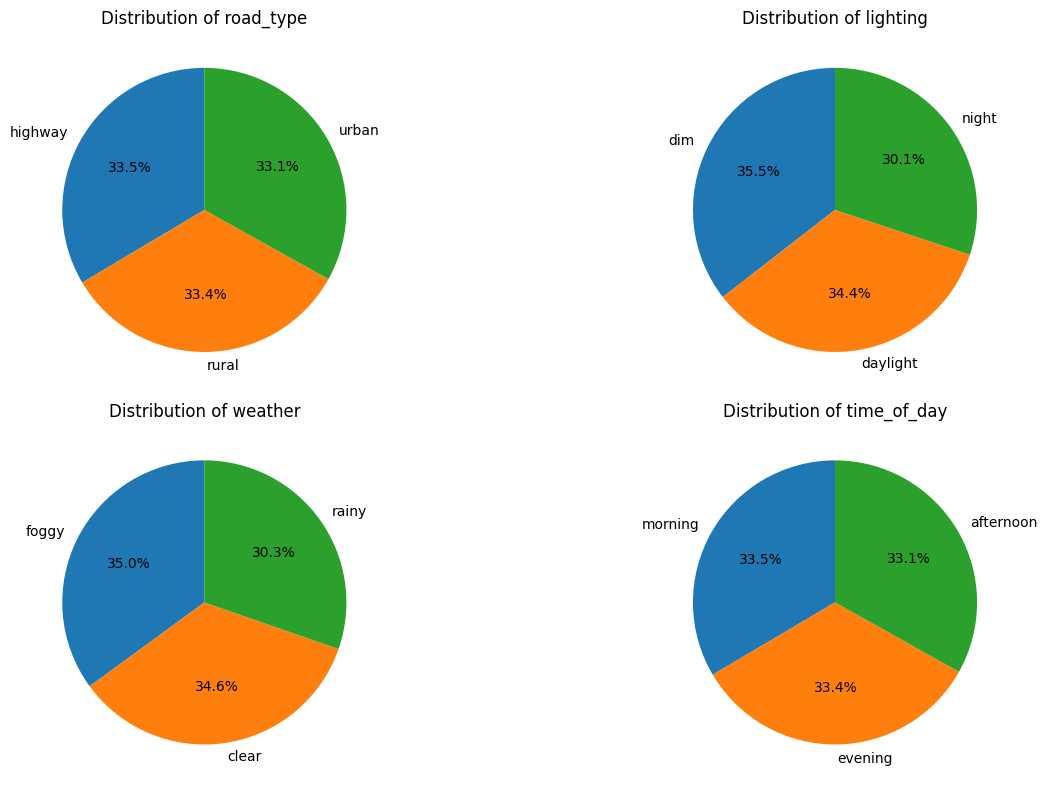

In [16]:
# categorical features
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

categorical_features = ['road_type', 'lighting', 'weather', 'time_of_day']

for i, feature in enumerate(categorical_features):
    row, col = i // 2, i % 2
    value_counts = df_train[feature].value_counts()
    axes[row, col].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [17]:
# boolean features summary
bool_features = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for feature in bool_features:
    print(df_train[feature].value_counts())
    print(f"True proportion: {df_train[feature].mean():.3f}")
    print()

road_signs_present
False    259289
True     258465
Name: count, dtype: int64
True proportion: 0.499

public_road
True     260045
False    257709
Name: count, dtype: int64
True proportion: 0.502

holiday
True     260688
False    257066
Name: count, dtype: int64
True proportion: 0.503

school_season
False    260164
True     257590
Name: count, dtype: int64
True proportion: 0.498



*   Road signs are present in about 49.9% of locations and absent in about 50.1%.
*   Approximately 50.2% of the roads are public.
*   About 50.3% of the data points are from holidays.
*   School season is active in about 49.8% of the data points.

### Analyze Average Accident Risk by Discrete Features

Identify which categories are associated with higher or lower accident risk.

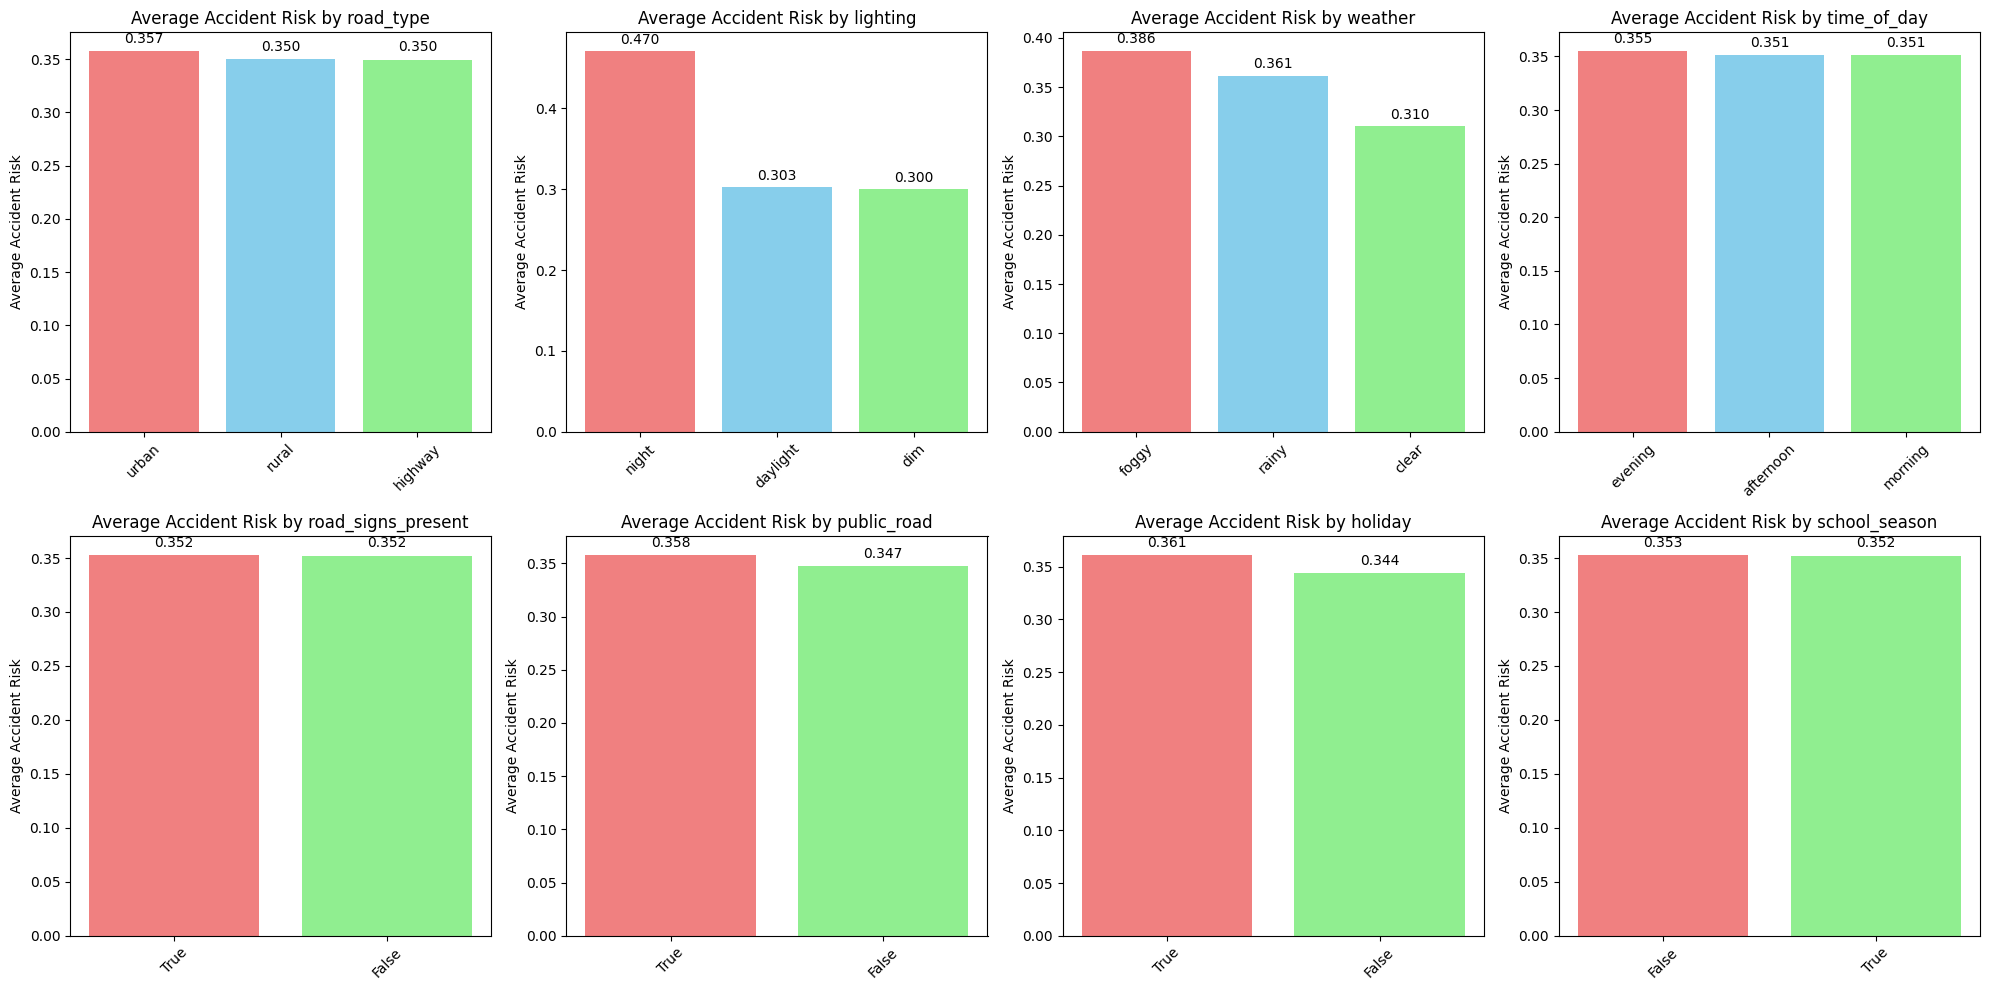

In [18]:
discrete_features = ['road_type', 'lighting', 'weather', 'time_of_day',
                     'road_signs_present', 'public_road', 'holiday', 'school_season']

# determine the number of rows and columns for subplots
n_rows = 2
n_cols = 4
n_features = len(discrete_features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
axes = axes.flatten()

for i, feature in enumerate(discrete_features):
    # calculate average accident risk for each category
    risk_by_category = df_train.groupby(feature)['accident_risk'].mean().sort_values(ascending=False)

    # determine colors for bars
    colors = []
    if len(risk_by_category) > 1:
        max_risk = risk_by_category.max()
        min_risk = risk_by_category.min()
        for risk in risk_by_category.values:
            if risk == max_risk:
                colors.append('lightcoral')
            elif risk == min_risk:
                colors.append('lightgreen')
            else:
                colors.append('skyblue')
    else:
        colors = ['skyblue']

    # Plotting
    bars = axes[i].bar(risk_by_category.index.astype(str), risk_by_category.values, color=colors)
    axes[i].set_title(f'Average Accident Risk by {feature}')
    axes[i].set_ylabel('Average Accident Risk')
    axes[i].tick_params(axis='x', rotation=45)

    # add value labels on top of bars
    for bar, value in zip(bars, risk_by_category.values):
        yval = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{value:.3f}', va='bottom', ha='center')

plt.tight_layout()
plt.show()

*   Urban roads have the highest average accident risk (0.357), slightly higher than rural (0.350) and highway (0.350) roads.
*   Nighttime conditions have a significantly higher average accident risk (0.470) compared to daylight (0.303) and dim (0.300) conditions.
*   Foggy weather is associated with the highest average accident risk (0.386), followed by rainy (0.361) and clear (0.310) weather.
*   Evening hours show a slightly higher average accident risk (0.355) compared to afternoon (0.351) and morning (0.351).
*   Locations with road signs present have a slightly higher average accident risk (0.352) than those without (0.352).
*   Public roads have a slightly higher average accident risk (0.358) compared to non-public roads (0.347).
*   Holidays are associated with a slightly higher average accident risk (0.361) than non-holidays (0.344).
*   School season has a slightly lower average accident risk (0.352) compared to non-school season (0.353).

### Distribution and Outliers

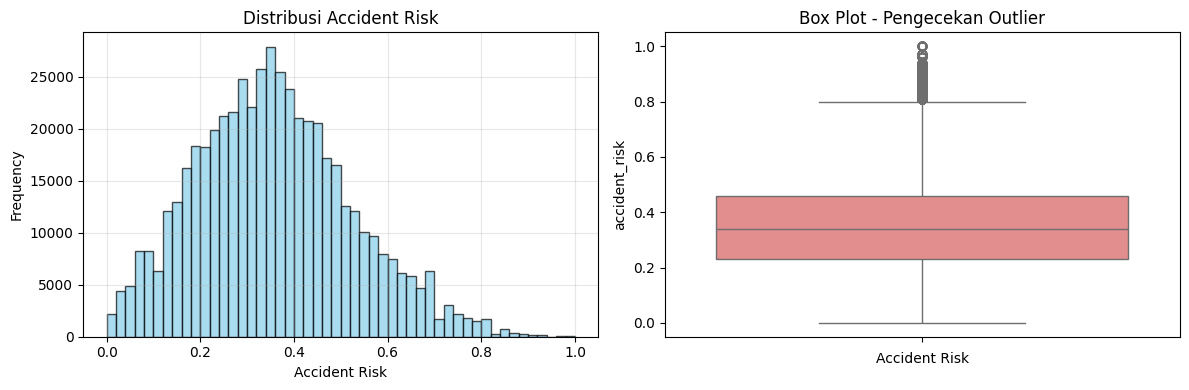

Rentang: 0.000 - 1.000
Rata-rata: 0.352
Skewness: 0.378


In [19]:
plt.figure(figsize=(12, 4))

# distribution
plt.subplot(1, 2, 1)
plt.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')
plt.title('Distribusi Accident Risk')
plt.grid(True, alpha=0.3)

# boxplot (cek outlier)
plt.subplot(1, 2, 2)
sns.boxplot(y=y, color='lightcoral')
plt.title('Box Plot - Pengecekan Outlier')
plt.xlabel('Accident Risk')

plt.tight_layout()
plt.show()

# insight target variable
print(f"Rentang: {y.min():.3f} - {y.max():.3f}")
print(f"Rata-rata: {y.mean():.3f}")
print(f"Skewness: {y.skew():.3f}")

*   The accident risk ranges from 0.000 to 1.000 and the average accident risk is 0.352, indicating a moderate risk level for most locations.
*   The skewness value is 0.378, which is close to zero, suggesting the distribution is relatively close to normal.
*   The box plot does not show any extreme outliers.

## Data Preprocessing (Preprocess categorical data)

In [20]:
# identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# apply label encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le

print(X.dtypes)

road_type                   int64
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                    int64
weather                     int64
road_signs_present           bool
public_road                  bool
time_of_day                 int64
holiday                      bool
school_season                bool
num_reported_accidents      int64
dtype: object


# Feature Engineering

In [21]:
# create feature copies
X_fe = X.copy()
X_test_fe = X_test.copy()

# add simple statistical features using only numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    X_fe['feat_sum'] = X[numeric_cols].sum(axis=1)
    X_test_fe['feat_sum'] = X_test[numeric_cols].sum(axis=1)

    X_fe['feat_mean'] = X[numeric_cols].mean(axis=1)
    X_test_fe['feat_mean'] = X_test[numeric_cols].mean(axis=1)

print("X_fe shape:", X_fe.shape, "X_test_fe shape:", X_test_fe.shape)

X_fe shape: (517754, 14) X_test_fe shape: (172585, 14)


# Split the Data

In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X_fe, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)

X_train: (414203, 14) y_train: (414203,)
X_val: (103551, 14) y_val: (103551,)


# Model Development

## Select and Train the Model

In [23]:
# initialize and train model
model = RandomForestRegressor(
    n_estimators=50,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=50, n_jobs=-1, random_state=42)

## Make Predictions

In [24]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Evaluate the Model

## Cross Validation

In [25]:
cv_scores = cross_val_score(
    model,
    X_fe,
    y,
    cv=5,  # 5 fold
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# calculate RMSE from MSE
cv_rmse_scores = np.sqrt(-cv_scores)

print(f"CV RMSE: {cv_rmse_scores}")
print(f"Mean CV RMSE: {cv_rmse_scores.mean():.4f}")

CV RMSE: [0.05691995 0.05624514 0.05667298 0.05660565 0.05636685]
Mean CV RMSE: 0.0566


## Calculate RMSE

In [26]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("Train RMSE:", round(train_rmse, 4))
print("Val RMSE:", round(val_rmse, 4))

Train RMSE: 0.0515
Val RMSE: 0.0567


## Check Bias and Variance

In [27]:
gap = train_rmse - val_rmse
print("Gap:", round(gap, 4))

if gap < -0.02:
    print("Overfit")
elif gap > 0.02:
    print("Underfit")
else:
    print("Good")

Gap: -0.0052
Good


## Feature Important Analysis

In [28]:
# feature importance analysis
feature_importance = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# feature importance ranking
for i, row in importance_df.iterrows():
    print(f"{row['feature']:25} {row['importance']:.3f}")

curvature                 0.360
lighting                  0.247
feat_sum                  0.166
feat_mean                 0.111
weather                   0.070
num_reported_accidents    0.034
speed_limit               0.003
num_lanes                 0.002
time_of_day               0.002
road_type                 0.002
holiday                   0.001
public_road               0.001
road_signs_present        0.001
school_season             0.001


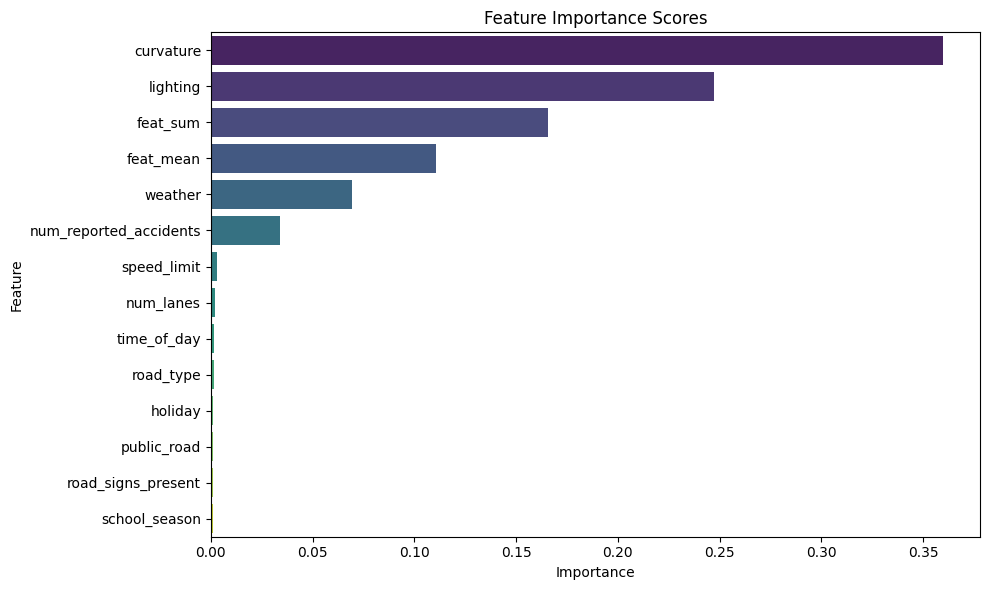

In [29]:
# plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis', hue='feature', legend=False)
plt.title('Feature Importance Scores')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

High Impact Factors:
- Curvature (36%)
- Lighting Conditions (24.7%)
- Weather Conditions (7%)

Action Recommendations:
- Prioritize safety measures on high-curvature roads, especially during bad lighting conditions
- Enhanced lighting infrastructure could provide the biggest safety improvement
- Weather-responsive speed limits may significantly reduce accident risk (adjust speed limits based on weather conditions)

Long-term Strategies:
- Focus road maintenance budgets on curved road segments
- Implement warning systems for dangerous road situations (high-risk)

# Test and Deploy Model

In [30]:
# fix features
X_test_fe_fixed = X_test_fe[X_train.columns]

# predict
test_predictions = model.predict(X_test_fe_fixed)

# create submission
submission = pd.DataFrame({
    'id': df_test['id'],
    'accident_risk': test_predictions
})

submission['accident_risk'] = submission['accident_risk'].clip(0, 1)
submission.to_csv('submission.csv', index=False)

print(submission.head())

       id  accident_risk
0  517754       0.313001
1  517755       0.122995
2  517756       0.179411
3  517757       0.319675
4  517758       0.417738
